## Experimentación con el número de equipos

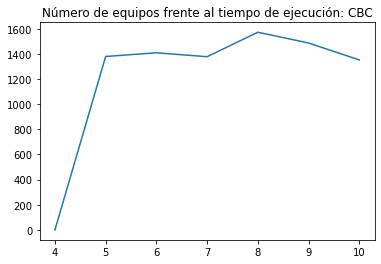

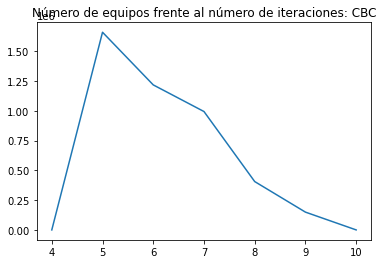

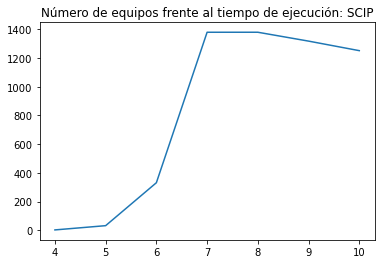

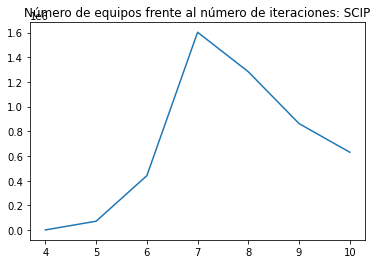

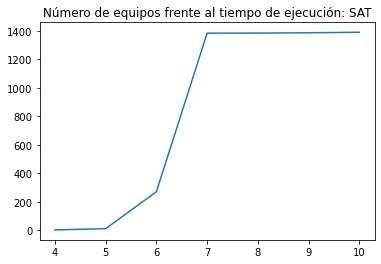

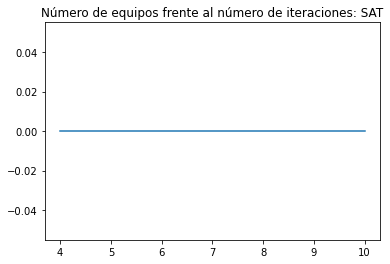

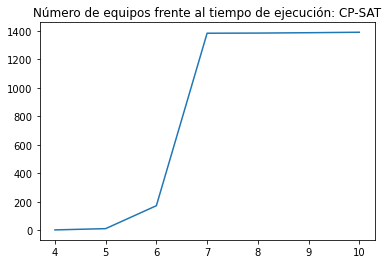

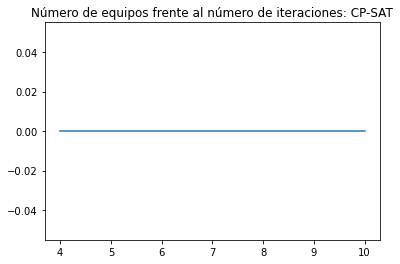

In [1]:
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from experimento import experimento
import pandas as pd


dfs = []
 # , 'SCIP', 'SAT', 'CP-SAT'
for j in ['CBC', 'SCIP', 'SAT', 'CP-SAT']:
    n_equipos, exec_time, n_iters, solvers, statuses = [], [], [], [], []
    for i in range(4,11):
        solver = pywraplp.Solver.CreateSolver(j) #CBC, SCIP, SAT, CP-SAT
#         solver.SetNumThreads(10)

        s, t = experimento(solver, i, 60 + 10*i-4, 23 * 60)

        n_equipos.append(i)
        exec_time.append(t)
        n_iters.append(solver.Iterations())
        solvers.append(j)
        statuses.append(s)
#         print(n_equipos,exec_time)
    dfs.append(pd.DataFrame({'n_equipos': n_equipos, 'exec_time': exec_time, 'n_iters': n_iters, 'solver': solvers, 'statuses':statuses}))
        
    plt.figure()
    plt.title(f'Número de equipos frente al tiempo de ejecución: {j}')
    plt.plot(n_equipos, exec_time)
    plt.savefig('resultados_equipos/'+j+'_exec_time.png', bbox_inches='tight')
        
    plt.figure()
    plt.title(f'Número de equipos frente al número de iteraciones: {j}')
    plt.plot(n_equipos, n_iters)
    plt.savefig('resultados_equipos/'+j+'_n_iters.png', bbox_inches='tight')

pd.concat(dfs, ignore_index=True).to_csv('results_nEquipos.csv', sep= ',', encoding='utf-8', index=False)

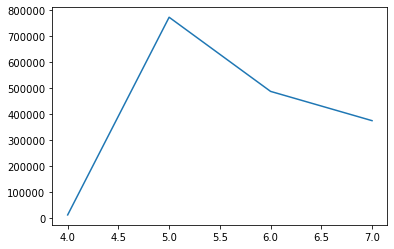

In [3]:
plt.plot(n_equipos, n_iters)

In [4]:
for s in statuses:
    print(s)

0
1
6
6


## Experimentación con distintos solvers

In [16]:
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from experimento import experimento
from collections import defaultdict

exec_time, n_iters, statuses = list(defaultdict(list) for i in range(3))

for i in ['CBC', 'SCIP', 'SAT', 'CP-SAT']:
    for j in range(50):
        solver = pywraplp.Solver.CreateSolver(i)

        s, t = experimento(solver, 4, 60, 3 * 60)

        exec_time[i].append(t)
        n_iters[i].append(solver.Iterations())
        statuses[i].append(s)

In [17]:
import pickle

results = {'exec_time' : exec_time, 'n_iters' : n_iters, 'statuses' : statuses}
with open('..\Data\experimentos.pkl', 'wb') as file:
    pickle.dump(results, file)

In [18]:
results

{'exec_time': defaultdict(list,
             {'CBC': [2.7493796348571777,
               3.0174450874328613,
               2.843316078186035,
               2.695974826812744,
               2.8108959197998047,
               2.6340391635894775,
               2.5727779865264893,
               2.5943849086761475,
               2.6181106567382812,
               2.6608498096466064,
               3.0946271419525146,
               2.5898168087005615,
               2.5709145069122314,
               2.572889566421509,
               2.6330161094665527,
               2.6076231002807617,
               2.554955244064331,
               2.672854423522949,
               2.698704719543457,
               2.5463435649871826,
               2.5948193073272705,
               2.6696436405181885,
               2.703050136566162,
               2.5651369094848633,
               2.6093051433563232,
               2.5843136310577393,
               2.641939401626587,
               2.5460472

In [24]:
import pandas as pd
df = pd.DataFrame()
df['CBC'] = results['exec_time']['CBC']
df['SCIP'] = results['exec_time']['SCIP']
df['SAT'] = results['exec_time']['SAT']
df['CP-SAT'] = results['exec_time']['CP-SAT']

In [25]:
# df.to_csv('../Data/execTime_by_solver.csv', index = False)